# Grover Search Algorithm

This notebook is an adapted version from https://github.com/QISKit/qiskit-tutorial. We show to to perform the Grover Search algorithm both on a local simulator and on the Quantum Inspire backend.

For more information about how to use the IBM Q Experience (QX), consult the [tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

*Contributors*
Pieter Eendebak, Giacomo Nannicini and Rudy Raymond (based on [this article](https://arxiv.org/abs/1708.03684)) 

# Introduction

Grover search is one of the most popular algorithms used for searching a solution among many possible candidates using Quantum Computers. If there are $N$ possible solutions among which there is exactly one solution (that can be verified by some function evaluation), then Grover search can be used to find the solution with $O(\sqrt{N})$ function evaluations. This is in contrast to classical computers that require $\Omega(N)$ function evaluations: the Grover search is a quantum algorithm that provably can be used search the correct solutions quadratically faster than its classical counterparts.  

Here, we are going to illustrate the use of Grover search to find a particular value in a binary number.
The key elements of Grovers algorithm are:
1. Initialization to a uniform superposition
2. The oracle function
3. Reflections (amplitude amplification)

In [1]:
from IPython.display import Math
import numpy as np
import itertools
import warnings
from colorama import Fore
from imp import reload

# importing the QISKit
import qiskit
from qiskit.tools.visualization import circuit_drawer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, QISKitError #, QuantumJob
from qiskit import available_backends, execute, register, get_backend, compile
from qiskit.tools.qi.qi import state_fidelity, concurrence, purity, outer
from qiskit.tools.visualization import plot_state, plot_histogram
from sympy.interactive import printing
printing.init_printing(use_latex='png')
from IPython.display import display, Math, Latex

from quantuminspire import QuantumInspireAPI
from quantuminspire.qitools import format_vector, run_circuit

# The oracle function

We implement an oracle function (black box) that acts as -1 on a single basis state, and +1 on all other status. 

None

black box circuit:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

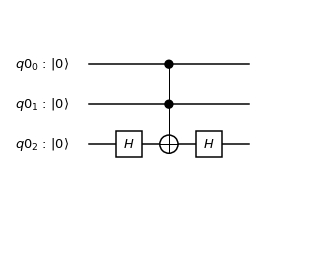

In [2]:
n=3
N=2**n
q = QuantumRegister(n)
qc = QuantumCircuit(q)

if n==1:
    def black_box(qc, q):    
        qc.z(q)
elif n==2:
    def black_box(qc, q):
        for i in range(n):
            	qc.s(q[i])
        qc.h(q[1])
        qc.cx(q[0], q[1])        
        qc.h(q[1])
        for i in range(n):
            	qc.s(q[i])
else:
    def black_box(qc, q):
        qc.h(q[2])
        qc.ccx(q[0], q[1], q[2])
        qc.h(q[2])
black_box(qc,q)
cplot=circuit_drawer(qc)
display(cplot)

print('black box circuit:')
run_circuit(qc, q)

# Inversion about the average

Another important procedure in Grover search is to have an operation that perfom the *inversion-about-the-average* step, namely, it performs the following transformation:

$$
\sum_{j=0}^{2^{n}-1} \alpha_j |j\rangle \rightarrow \sum_{j=0}^{2^{n}-1}\left(2 \left( \sum_{k=0}^{k=2^{n}-1} \frac{\alpha_k}{2^n} \right) - \alpha_j  \right) |j\rangle 
$$

The above transformation can be used to amplify the probability amplitude $\alpha_s$ when s is the solution and $\alpha_s$ is negative (and small), while $\alpha_j$ for $j \neq s$ is positive. Roughly speaking, the value of $\alpha_s$ increases by twice the average of the amplitudes, while others are reduced. The inversion-about-the-average can be realized with the sequence of unitary matrices as below:

$$
H^{\otimes n} \left(2|0\rangle \langle 0 | - I \right) H^{\otimes n}
$$

The first and last $H$ are just Hadamard gates applied to each qubit. The operation in the middle requires us to design a sub-circuit that flips the probability amplitude of the component of the quantum state corresponding to the all-zero binary string. The sub-circuit can be realized by the following function, which is a multi-qubit controlled-Z which flips the probability amplitude of the component of the quantum state corresponding to the all-one binary string. Applying X gates to all qubits before and after the function realizes the sub-circuit. 

In [3]:
def n_controlled_Z(circuit, controls, target):
    """Implement a Z gate with multiple controls"""
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 ' +
                         'controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)

Finally, the inversion-about-the-average circuit can be realized by the following function:

In [4]:
def inversion_about_average(circuit, f_in, n):
    """Apply inversion about the average step of Grover's algorithm."""
    # Hadamards everywhere
    if n==1:
        circuit.x(f_in[0])
        return
    for j in range(n):
        circuit.h(f_in[j])
    # D matrix: flips the sign of the state |000> only
    for j in range(n):
        circuit.x(f_in[j])
    n_controlled_Z(circuit, [f_in[j] for j in range(n-1)], f_in[n-1])
    for j in range(n):
        circuit.x(f_in[j])
    # Hadamards everywhere again
    for j in range(n):
        circuit.h(f_in[j])

We show the circuit that performs inversion about the average on $n$ qubits. We also show the effect of the circuit on the basis states.

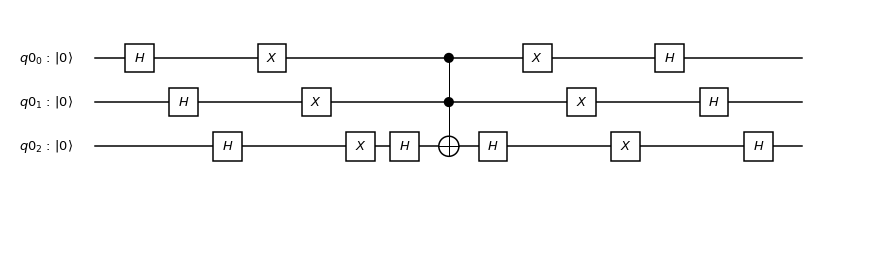

In [5]:
qInvAvg = QuantumCircuit(q)
inversion_about_average(qInvAvg, q, n)
circuit_drawer(qInvAvg)

In [6]:
print('inversion average circuit:')
qc = QuantumCircuit(q)
inversion_about_average(qc, q, n)        
run_circuit(qc, q, n=n)

inversion average circuit:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Grover Search: putting all together

The complete steps of Grover search is as follow.

1. Create the superposition of all possible solutions as the initial state (with working qubits initialized to zero)
$$  \sum_{j=0}^{2^{n}-1} \frac{1}{2^n} |j\rangle |0\rangle$$
2. Repeat for $T$ times:
    * Apply the blackbox function
    * Apply the inversion-about-the-average function
    
3. Measure to obtain the solution

Before we go to the code to perform the Grover search we make some remarks on the number of repetitions $T$ that we have to perform (for details see [Grover algorithm, Wikipedia](https://en.wikipedia.org/wiki/Grover%27s_algorithm)).

Each Grover step rotates the 'winner solution' by a fixed angle. This means that after a certain number of steps we arrive at the optimal approximation (e.g. the amplitude of the winner solution is maximal). If we then apply more iterations, the quality of our result will go _down_. For a database of size $N=2^n$ the optimal number of iterations is
$$r=\pi \sqrt{N}/4$$

In [7]:
theta = 2*np.arcsin(1/np.sqrt(N))
r=np.pi*np.sqrt(N)/4
display(Math(r'\textrm{Rotation of the winner: } \theta = %.2f \mathrm{\ [deg]}' % (np.rad2deg(theta))) )
print('Optimal number of Grover iterations for n=%d: %.1f' % (n,r) )
T=int(r)

<IPython.core.display.Math object>

Optimal number of Grover iterations for n=3: 2.2


The probablity of the winner state after $T$ iterations is $\sin( (T+1/2)\theta)^2$

In [8]:
for i in range( int(r+2) ):
    p=np.sin( (i+1/2)*theta)**2
    print('%d iterations: p %.2f' % (i, p))

0 iterations: p 0.12
1 iterations: p 0.78
2 iterations: p 0.95
3 iterations: p 0.33


Finally we define the complete circuit for Grovers algorithm, excute it and show the results.

<IPython.core.display.Math object>

number of iterations T=2


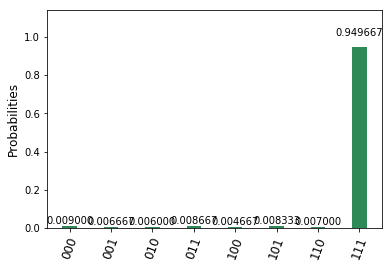

In [9]:
"""Grover search implemented in QISKit.

This module contains the code necessary to run Grover search on 3
qubits, both with a simulator and with a real quantum computing
device. This code is the companion for the paper
"An introduction to quantum computing, without the physics",
Giacomo Nannicini, https://arxiv.org/abs/1708.03684.

"""
from qiskit import QuantumProgram
from qiskit.tools import visualization

def input_state(circuit, f_in, n):
    """(n+1)-qubit input state for Grover search."""
    for j in range(n):
        circuit.h(f_in[j])

QPS_SPECS = {
    'circuits': [{
        'name': 'grover',
        'quantum_registers': [
            {'name': 'q', 'size': n},
        ],
        'classical_registers': [
            {'name': 'ans', 'size': n},
        ]}]
}

circuitName='grover'
qp = QuantumProgram(specs=QPS_SPECS)
qc = qp.get_circuit('grover')
q = qp.get_quantum_register('q')
ans = qp.get_classical_register('ans')

input_state(qc, q, n)

result = qp.execute(['grover'], backend='local_statevector_simulator', shots=10)
state_vector = result.get_statevector(qc)
m=display( Math('\mathrm{state\ after\ initialization:\ }' +format_vector(state_vector)))

# apply T rounds of oracle and inversion about the average
print('number of iterations T=%d'% T)
for t in range(T):
    for i in range(n):
        qc.barrier(q[i]) # for better visualization
    qc.iden(q[0])
    # Apply T full iterations
    black_box(qc, q)
    for i in range(n):
        qc.barrier(q[i])
    qc.iden(q[0])
    inversion_about_average(qc, q, n)

# Measure the output register in the computational basis
for j in range(n):
    qc.measure(q[j], ans[j])

# Execute circuit
result = qp.execute(['grover'], backend='local_qasm_simulator', shots=n*1000)
# Get counts and plot histogram
counts = result.get_counts('grover')
visualization.plot_histogram(counts)

As expected, the state that is indicated by the oracle function has the highest probability of begin measured.

We show the full circuit that was generated by the code.

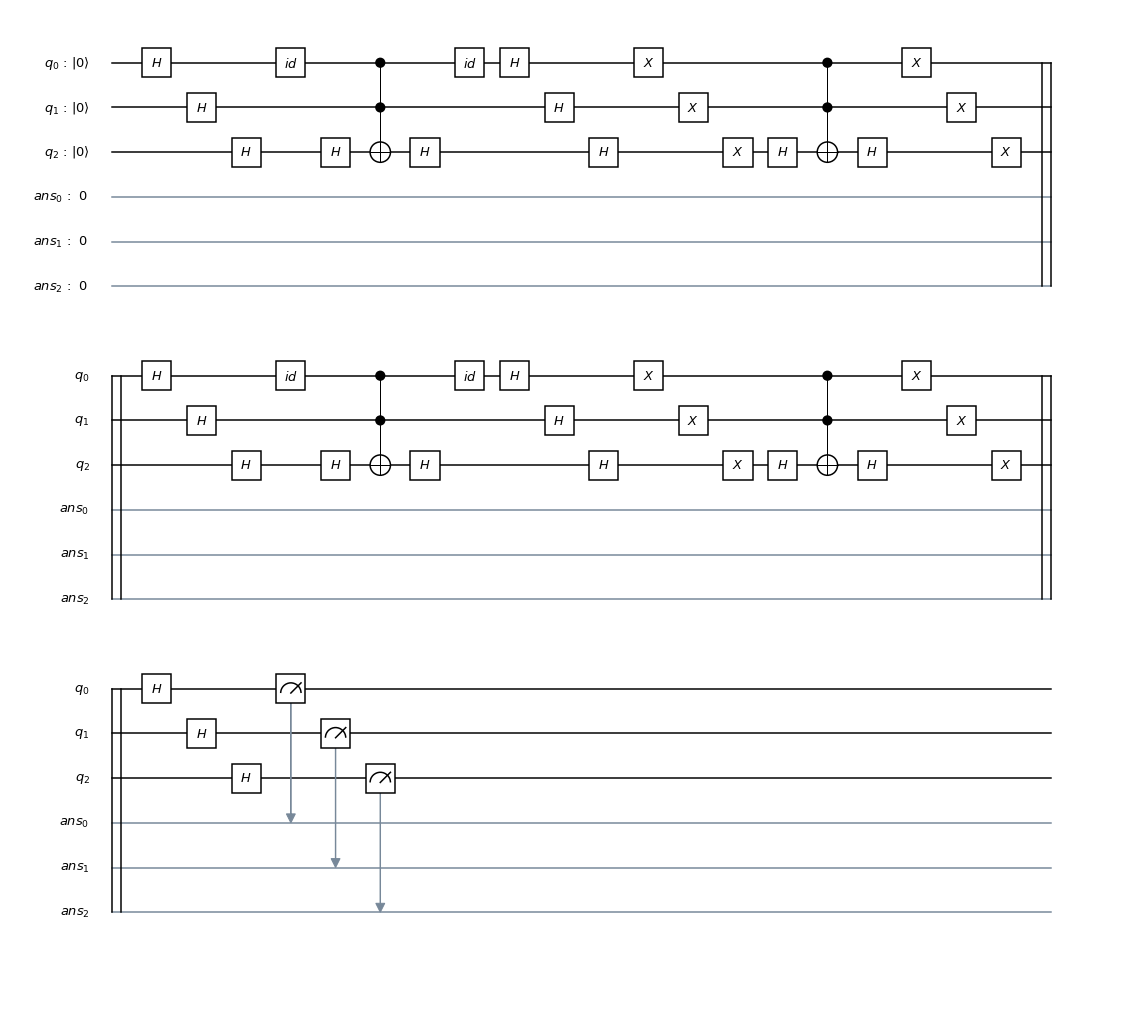

In [10]:
circuit_drawer(qp.get_circuit(circuitName))

# Run the cirquit on the Quantum Inspire simulator

First we make a connection to the Quantum Inspire website.

In [14]:
from quantuminspire.qitools import QuantumInspireAPI
from requests.auth import HTTPBasicAuth
from getpass import getpass

try:
    passwd
except:
    print('Enter username')
    username = input();
    print('Enter password')
    passwd = getpass();

auth = HTTPBasicAuth(username, passwd)
qi = QuantumInspireAPI(server=r'https://api.quantum-inspire.com/', auth=auth)  
_=qi.list_backend_types()   

backend: QX Single-node Simulator (qubits 26)
backend: QX Single-node Simulator SurfSara (qubits 31)
backend: QX Multi-node Simulator (qubits 37)
backend: 10-Qubit NV Center (qubits 10)
backend: 17-Qubit Transmon (qubits 17)
backend: 2-Qubit Silicon Spin (qubits 2)
backend: 5-Qubit Silicon Spin (qubits 5)


We can list backends and perform other functions with the `QuantumInspireAPI`.

In [16]:
_=qi.list_backend_types()

backend: QX Single-node Simulator (qubits 26)
backend: QX Single-node Simulator SurfSara (qubits 31)
backend: QX Multi-node Simulator (qubits 37)
backend: 10-Qubit NV Center (qubits 10)
backend: 17-Qubit Transmon (qubits 17)
backend: 2-Qubit Silicon Spin (qubits 2)
backend: 5-Qubit Silicon Spin (qubits 5)


We create a QisKit backend for the Quantum Inspire interface and execute the circuit generated above.

In [17]:
from quantuminspire.qiskit.qiskit_backend import QiSimulatorPy
backend=QiSimulatorPy(qi_api=qi)    
j=execute(qc, backend)

backend: QX Single-node Simulator (qubits 26)
backend: QX Single-node Simulator SurfSara (qubits 31)
backend: QX Multi-node Simulator (qubits 37)
backend: 10-Qubit NV Center (qubits 10)
backend: 17-Qubit Transmon (qubits 17)
backend: 2-Qubit Silicon Spin (qubits 2)
backend: 5-Qubit Silicon Spin (qubits 5)
run_circuit: number_of_shots 1024
generate_cqasm: 3 qubits

submitting qasm code to quantum inspire qi-sdk-job-089bb084-970a-11e8-8385-0800271e4a8b
waiting for result of job 362 (iteration 0)
waiting for result of job 362 (iteration 1)
waiting for result of job 362 (iteration 2)
waiting for result of job 362 (iteration 3)
waiting for result of job 362 (iteration 4)
waiting for result of job 362 (iteration 5)
waiting for result of job 362 (iteration 6)
waiting for result of job 362 (iteration 7)
waiting for result of job 362 (iteration 8)
waiting for result of job 362 (iteration 9)
waiting for result of job 362 (iteration 10)
waiting for result of job 362 (iteration 11)
waiting for res

We can print the results and also show the cQASM that was generated.

In [18]:
print(Fore.BLUE+'Generated histogram:' + Fore.RESET)
print(j.get_counts())
print(Fore.BLUE+'Generated cQASM:' + Fore.RESET)
print(backend._cqasm[0:101] + '\n....\n' + backend._cqasm[-100:])

Generated histogram:
{'2': 10.0, '5': 8.0, '3': 7.0, '7': 972.0, '6': 9.0, '4': 6.0, '1': 8.0, '0': 4.0}
Generated cQASM:
version 1.0
# cqasm generated by QI backend for QisKit
qubits 3
H q[2]
H q[2]
H q[2]
H q[1]
CNOT q[1]
....
q[0], q[1]
X q[1]
H q[1]
X q[0]
H q[0]
.measurement
   measure q[0]
   measure q[1]
   measure q[2]



Visualization can be done with the normal Python plotting routines, or with the QisKit SDK.

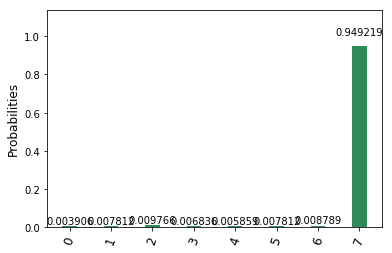

In [19]:
plot_histogram(j.get_counts(qc))

A screenshot from the execution result on the Quantum Inspire website.

![title](grover-qi.png)

## References

[1] "[A fast quantum mechanical algorithm for database search](https://arxiv.org/abs/quant-ph/9605043)", L. K. Grover, Proceedings of the 28th Annual ACM Symposium on the Theory of Computing (STOC 1996)

[2] "[Tight bounds on quantum searching](https://arxiv.org/abs/quant-ph/9605034)", Boyer et al., Fortsch.Phys.46:493-506,1998

[3] "[Quantum Inspire](https://www.quantum-inspire.com/)"

# Debugging code

In [107]:
#plot_state(rho,'paulivec')
#_=plot_state(rho, 'city')

## Format code

In [106]:
display(Math(format_vector([0,.1,-0.2,0,-1+2j,-1,0,0])))

<IPython.core.display.Math object>

## Run statevector simulator

In [105]:
qp = QuantumProgram(specs=QPS_SPECS)
qc = qp.get_circuit('grover')
q = qp.get_quantum_register('q')
ans = qp.get_classical_register('ans')

input_state(qc, q, n)

result = qp.execute(['grover'], backend='local_statevector_simulator', shots=10)
state_vector = result.get_statevector(qc)
m=display( Math('\mathrm{state\ after\ initialization:\ }' +format_vector(state_vector)))

# apply T rounds of oracle and inversion about the average
print('number of iterations T=%d'% T)
T=3
for t in range(T):
    for i in range(n):
        qc.barrier(q[i]) # for better visualization
    qc.iden(q[0])
    # Apply T full iterations
    black_box(qc, q)
    for i in range(n):
        qc.barrier(q[i])
    qc.iden(q[0])
    inversion_about_average(qc, q, n)

# Execute circuit with state vector simulator
result = qp.execute(['grover'], backend='local_statevector_simulator', shots=10000)
state_vector = result.get_statevector(qc)
m=display( Math('\mathrm{state\ final:\ }' +format_vector(state_vector)))


<IPython.core.display.Math object>

number of iterations T=3


<IPython.core.display.Math object>